# Cómputo Cuántico en la nube

## 1. Configuración

Se debe contar con las siguientes bibliotecas: 
```shell 
pip install matplotlib pylatexenc 
pip install qiskit qiskit-ibm-provider qiskit-ibm-runtime qiskit-aer 
``` 

In [36]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import qasm2
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler
from qiskit_ibm_provider import IBMProvider, least_busy
import numpy  as np

Crear una cuenta en: [IBM Quantum Platform](https://quantum.ibm.com/). Iniciar sesión en ir a Dashboard. 

![Screenshot from 2024-09-23 10-12-03.png](<attachment:Screenshot from 2024-09-23 10-12-03.png>)
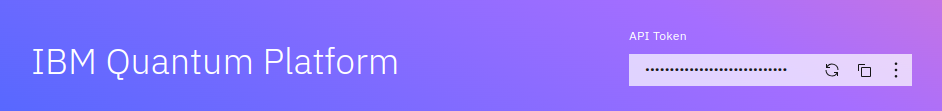

Copiar el API Token

Si es la primera vez que se ejecuta las siguientes líneas, el token se guarda en el disco duro en la dirección **$HOME/.qiskit/qiskit-ibm.json**. 

Solo debe ejecutarse una vez **QiskitRuntimeService.save_account()** para que se guarde el token. 

In [ ]:
API_token = ""
QiskitRuntimeService.save_account(channel="ibm_quantum", token=API_token)

Verificar que se tenga acceso a los servidores

In [ ]:
provider = IBMProvider()

Argumentos para crear los diagramas

In [31]:
draw_kwargs = {
        "output": "mpl",        # matplotlib
        "cregbundle": False,    # separa los cables
        "initial_state": True,  # muestra |0>
        "idle_wires": False,    # no mostar cables sin utilizar
    "style": {
        "subfontsize": 9,       # tamaño
        "dpi": 600
    }
}

## 2. Compuertas y Circuitos Cuánticos

Para visualizar la acción de las compuertas cuánticas es conveniente utilizar un simulador de la 
esfera de Bloch [Bloch Sphere Simulator](https://bloch.kherb.io/).
Los circuitos cuánticos puede ser construidos interactivamente con la herramienta de IBM
[IBM Quantum Composer](https://quantum.ibm.com/composer).

### 2.1 Circuitos de 1 qubit

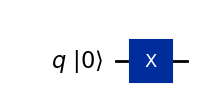

In [32]:
# Se inicia definiendo a los registros. Un registro cuántico como 
# q y un registro clásico como meas.
qreg_q = QuantumRegister(1, "q")
creg_c = ClassicalRegister(1, "meas")

# Creación de un circuito
qc = QuantumCircuit(qreg_q, creg_c)

# Compuerta X
qc.x(qreg_q[0])
qc.draw(**draw_kwargs)

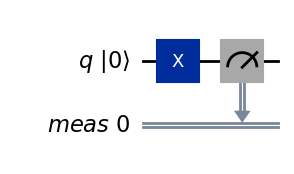

In [33]:
qc.measure(qreg_q[0], creg_c[0])
qc.draw(**draw_kwargs)

### 2.2 Simulación

In [35]:
simulator = AerSimulator()
result = simulator.run(qc, shots = 64).result()
counts = result.get_counts(0)
print(counts)

{'1': 64}


In [37]:
print(qasm2.dumps(qc))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[1];
creg meas[1];
x q[0];
measure q[0] -> meas[0];


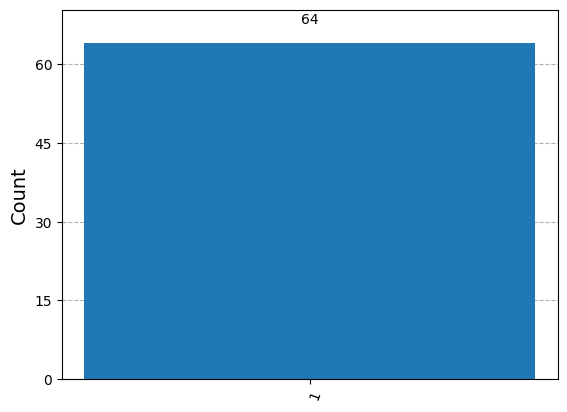

In [38]:
plot_histogram(counts)

### 2.3 Más de 1 qubit
Entrelazamiento cuántico

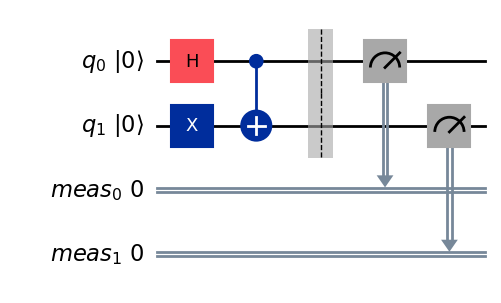

In [44]:
bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()
bell.draw(**draw_kwargs)

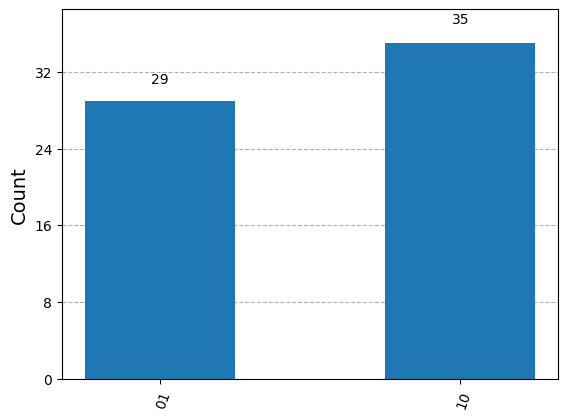

In [48]:
simulator = AerSimulator()
result = simulator.run(bell, shots = 64).result()
counts = result.get_counts(0)
plot_histogram(counts)

## 3. Hardware Cuántico

In [8]:
provider = IBMProvider()
print("Nombre del sistema           Número de Qubits")
print("---------------------------------------------")
print(provider.backends())
for backend in provider.backends():
    config = backend.configuration()
    print(f"{config.backend_name:22}       {config.n_qubits:>3}")

RequestsApiError: '401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. Login failed., Error code: 3446.'

In [ ]:
device = least_busy(provider.backends(
    filters=lambda x : x.configuration().n_qubits >=3 and
        not x.configuration().simulator
        and x.status().operational == True
))

## 4. Algoritmo de Shor

In [16]:
def fx_amod15(a, power):
    U = QuantumCircuit(4)
    for i in range(power):
        U.swap(2,3)
        U.swap(1,2)
        U.swap(0,1)
        for q in range(4):
            U.x(q)
    U = U.to_gate()
    U.name = "%i ^ %i mod 15"%(a,power)
    c_U = U.control()
    return c_U

In [17]:
def QFTi(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for k in range(j):
            if k != j:
                qc.cu(-np.pi/float(2**(j-k)), 0, 0, 0, k, j)
        qc.h(j)
    qc.name = "QFTi"
    return qc

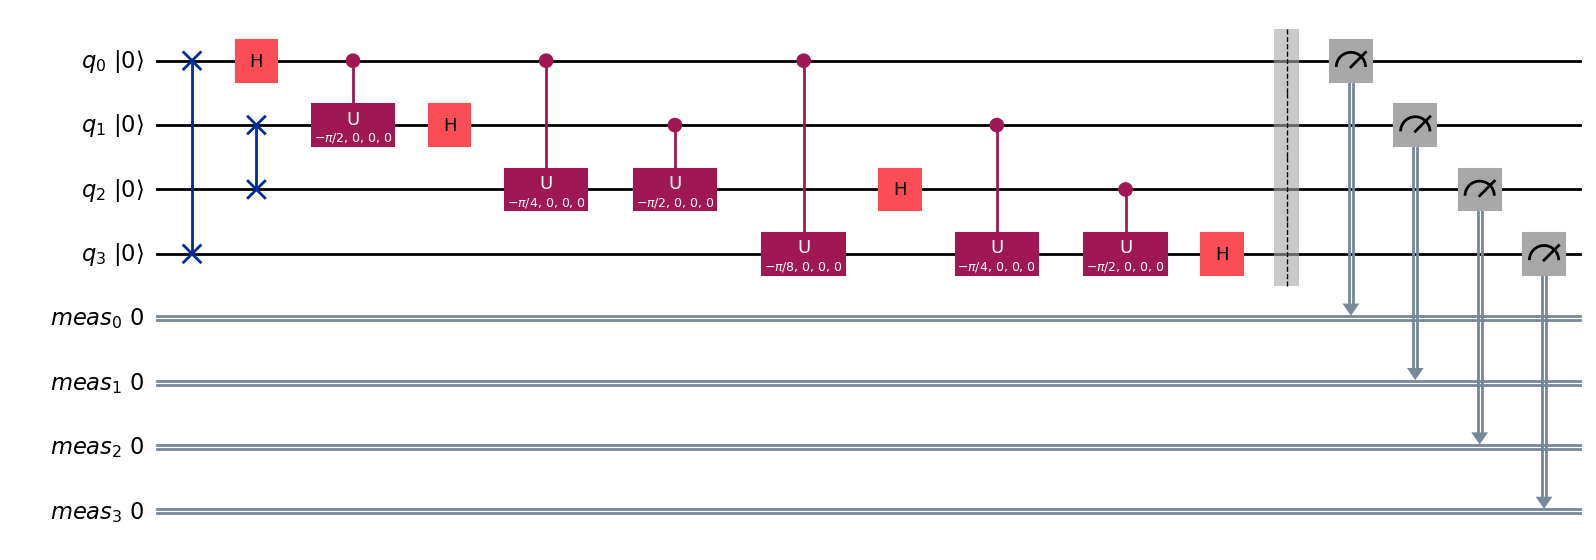

In [18]:
qc = QFTi(4)
qc.measure_all()
qc.draw(**draw_kwargs)

In [19]:
n_qubits = 8 #num qubits
a = 7       # base

In [20]:
qc = QuantumCircuit(n_qubits+4, n_qubits)

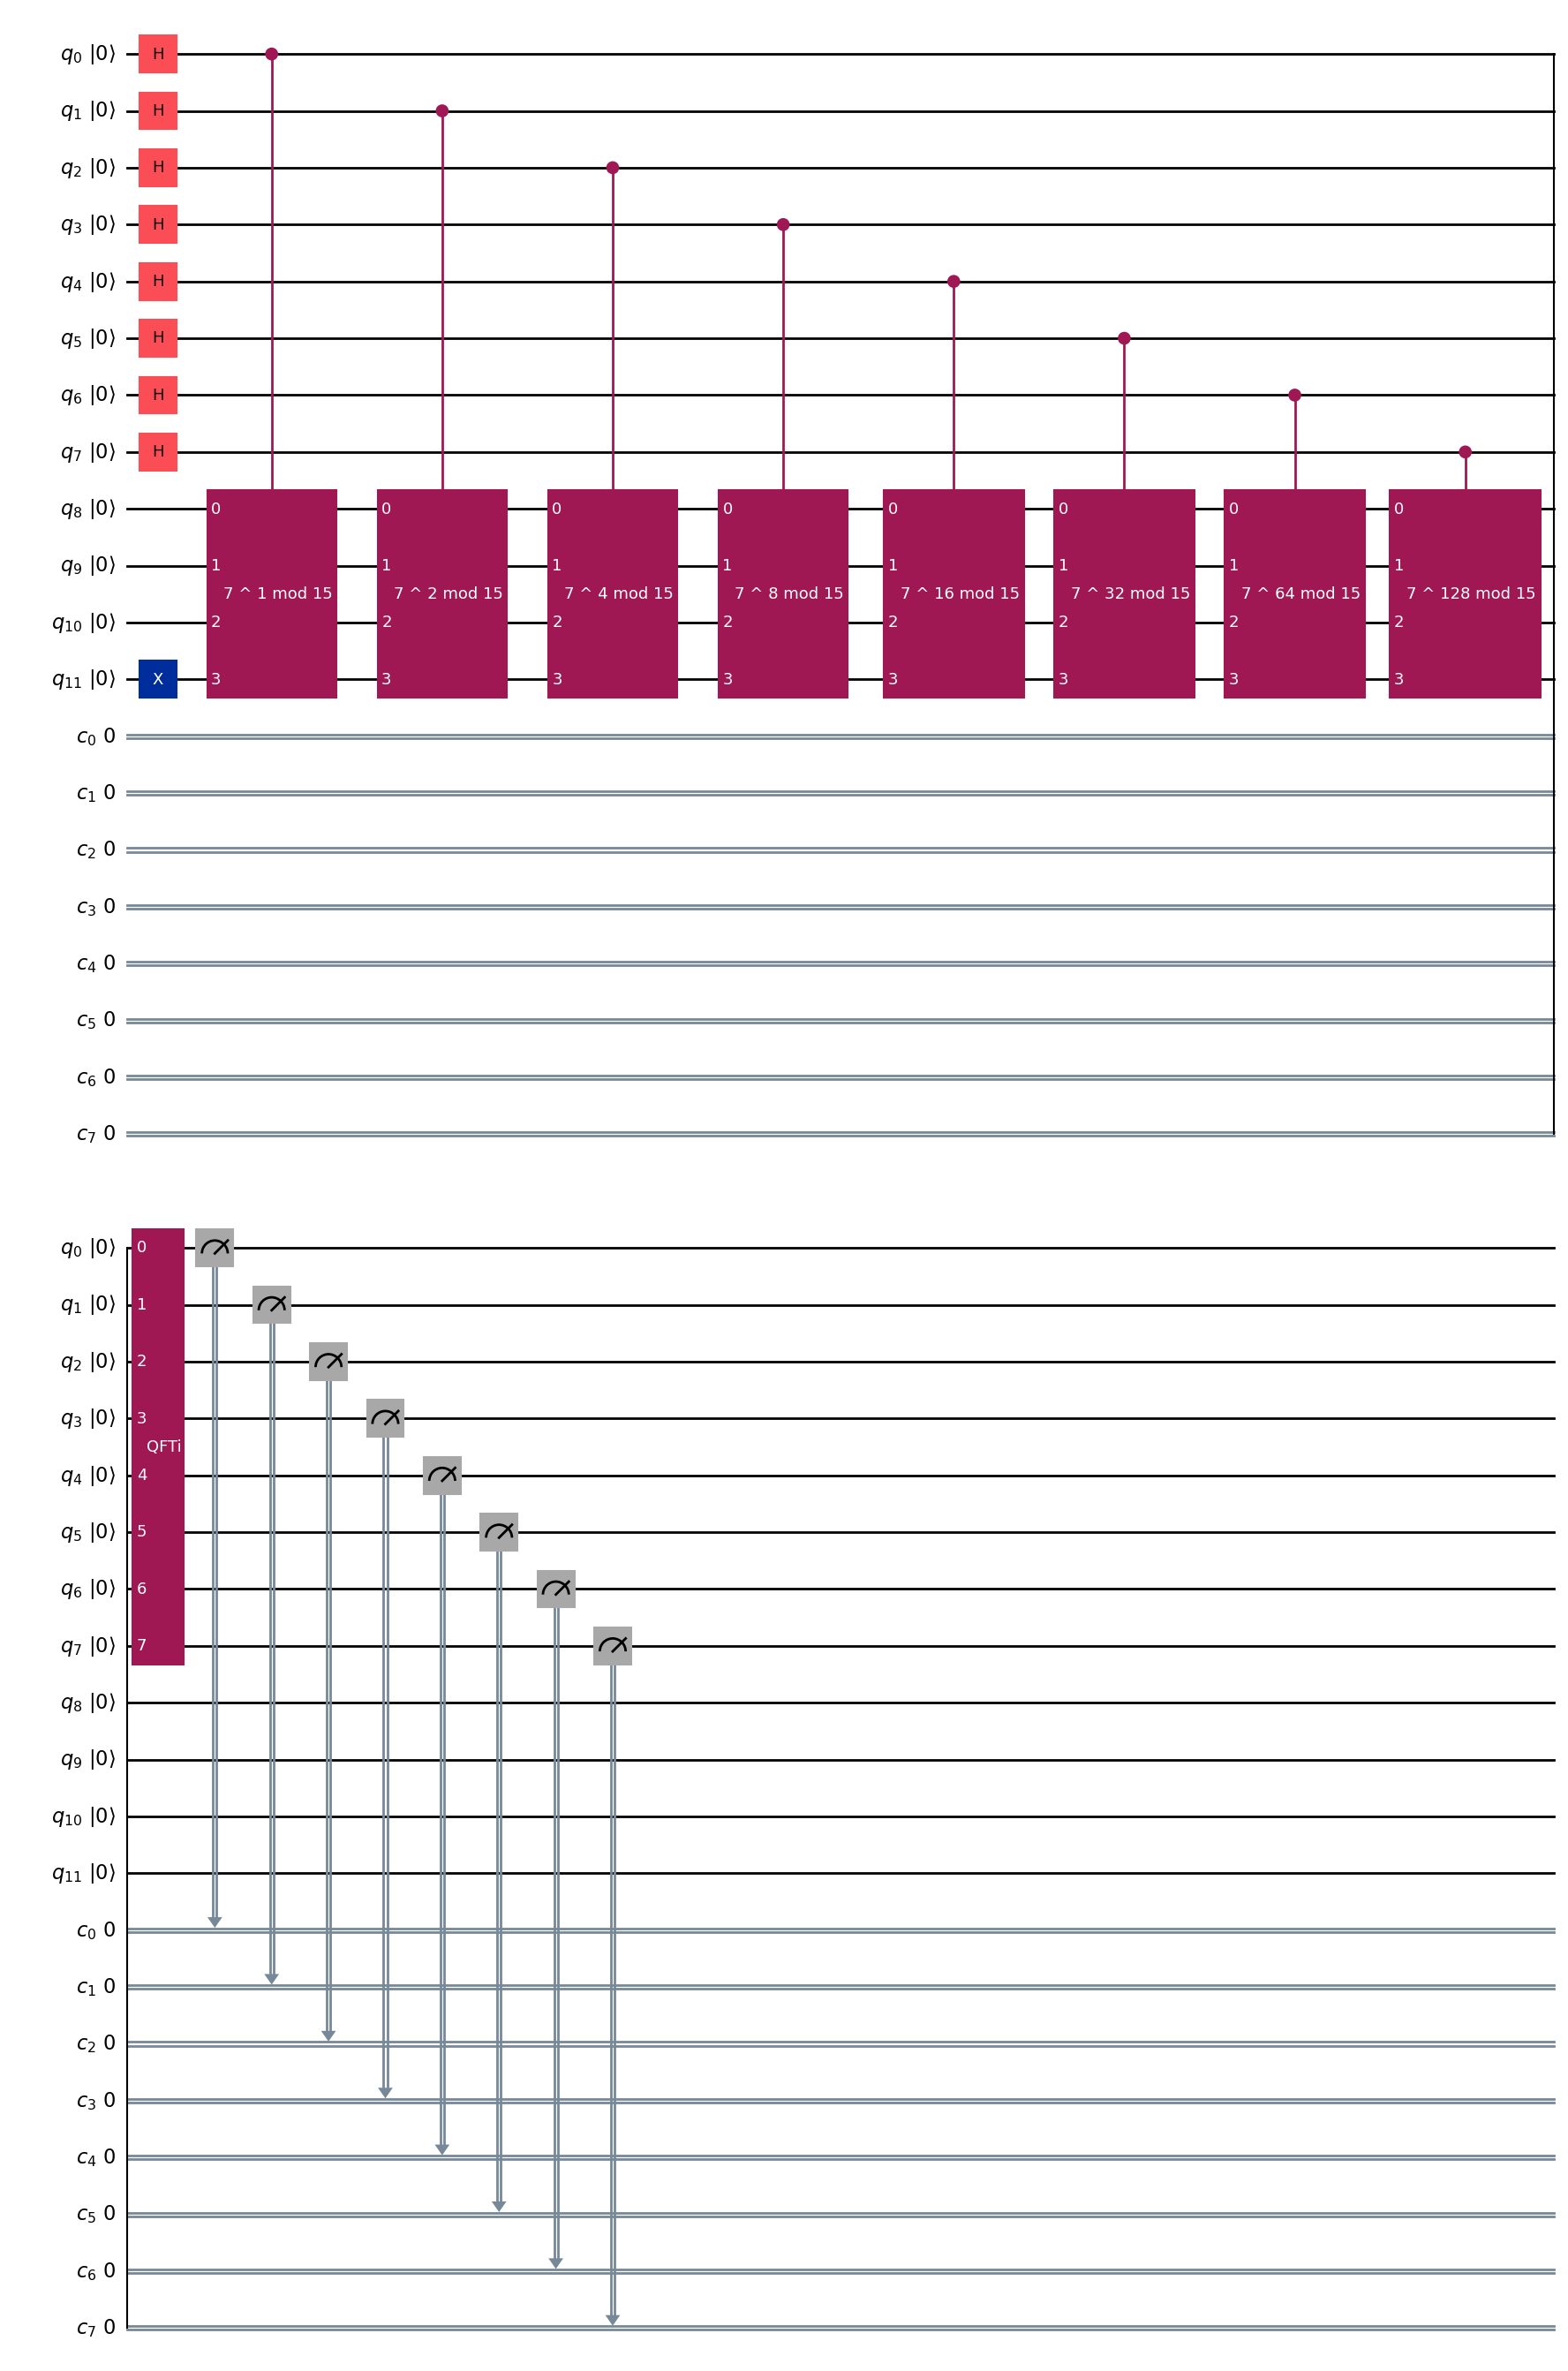

In [21]:
for q in range(n_qubits):
    qc.h(q)
qc.x(3+n_qubits)
for q in range(n_qubits):
    qc.append(fx_amod15(a,2**q), [q]+[i + n_qubits for i in range(4)])
qc.append(QFTi(n_qubits), range(n_qubits))
qc.measure(range(n_qubits), range(n_qubits))
qc.draw(**draw_kwargs)

Resultados: {'10000000': 238, '11000000': 243, '00000000': 284, '01000000': 259}


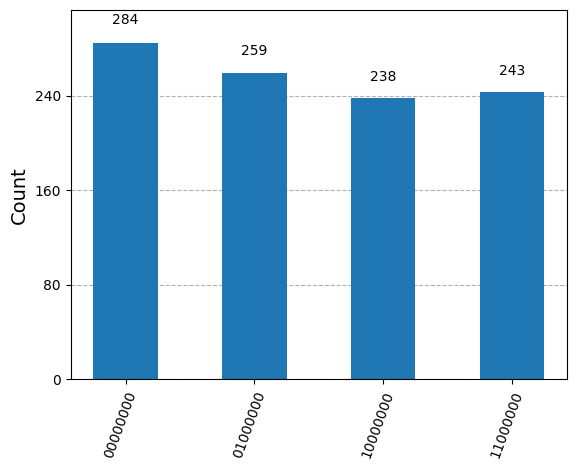

In [25]:
# Simulamos el circuito

simulator = AerSimulator()
qc_dec = qc.decompose()
result = simulator.run(qc_dec, shots=1024).result()
# counts = result.get_counts(circuit)
counts = result.get_counts(0)
counts
# Visualizamos los resultados
print("Resultados:", counts)
plot_histogram(counts)

     ┌───┐                                                         ┌─┐      
q_0: ┤ H ├─■────────■─────────────────■────────────────────────────┤M├──────
     ├───┤ │        │                 │                            └╥┘   ┌─┐
q_1: ┤ H ├─┼────────┼─────────────────┼────────────────────■────────╫────┤M├
     ├───┤ │        │                 │                ┌─┐ │        ║    └╥┘
q_2: ┤ H ├─┼────────┼────────■────────┼────────────────┤M├─┼────────╫─────╫─
     ├───┤ │        │        │        │                └╥┘ │        ║ ┌─┐ ║ 
q_3: ┤ H ├─┼────────┼────────┼────────┼────────■────────╫──┼────────╫─┤M├─╫─
     └───┘ │P(π/2)  │        │P(π/2)  │        │P(π/2)  ║  │        ║ └╥┘ ║ 
q_4: ──────■────────┼────────■────────┼────────■────────╫──┼────────╫──╫──╫─
                    │P(π/4)           │                 ║  │        ║  ║  ║ 
q_5: ───────────────■─────────────────┼─────────────────╫──┼────────╫──╫──╫─
                                      │P(π/8)           ║  │P(π/8)  ║  ║  ║ 

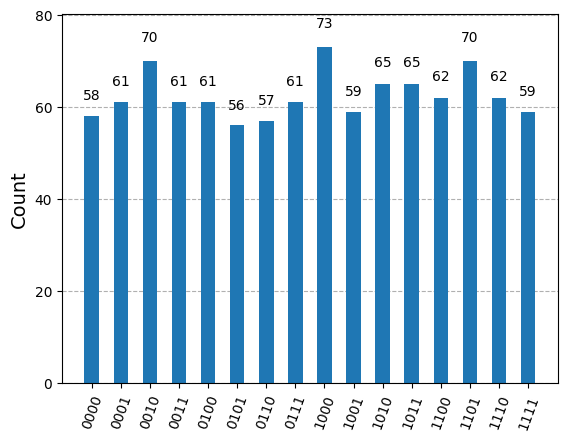

In [3]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Parámetros
a = 7
N = 15
num_qubits = 4  # Número de qubits para la entrada
num_ancilla = 3  # Qubits auxiliares

# Función para implementar la exponenciación modular
def modular_exponentiation(circuit, a, N, num_qubits, ancilla_qubits):
# Iterar sobre cada qubit de entrada
    for i in range(num_qubits):
        x = 2 ** i  # Valor de x
        power = a ** x % N
        
        # Implementación de puertas controladas
        for j in range(num_ancilla):
            # Controlamos la aplicación de la rotación Z
            if (power >> j) & 1:
                circuit.cp(np.pi / 2 ** (j + 1), i, ancilla_qubits[j])  # Usar i como control


# Construimos el circuito
qc = QuantumCircuit(num_qubits + num_ancilla, num_qubits)

# Inicializamos los qubits de entrada
for i in range(num_qubits):
    qc.h(i)  # Aplicar Hadamard para crear superposición

# Aplicamos la exponenciación modular
modular_exponentiation(qc, a, N, num_qubits, range(num_qubits, num_qubits + num_ancilla))

# Medimos los qubits
qc.measure(range(num_qubits), range(num_qubits))

# Visualizamos el circuito
print(qc)

# Simulamos el circuito

simulator = AerSimulator()
result = simulator.run(qc, shots=1000).result()
# counts = result.get_counts(circuit)
counts = result.get_counts(0)
counts
# Visualizamos los resultados
print("Resultados:", counts)
plot_histogram(counts)
